# 📝 Technical Report: Automated Grammar Scoring Engine

## 1. Overview
This notebook presents a multi-modal Deep Learning solution for automated grammar scoring (0.0 - 5.0). The approach fuses acoustic features (WavLM) with semantic and syntactic features (DeBERTa, Qwen 2.5) to robustly predict grammar quality from spoken audio.

## 2. Methodology & Architecture
Our solution treats the problem as a regression task using a **Hybrid Stacking Ensemble**.

### A. Preprocessing & Feature Extraction
1.  **Audio Processing:** 
    *   Raw audio is resampled to 16kHz using `librosa`.
    *   **ASR (Automatic Speech Recognition):** `OpenAI Whisper (Medium)` is used to transcribe audio to text with timestamps to calculate speech fluency metrics (speaking rate, silence ratio).
2.  **Feature Engineering (Multi-Modal):**
    *   **Acoustic Embeddings:** We use **WavLM (Microsoft)** to extract dense representations of the audio signal, capturing prosody and hesitation markers.
    *   **Semantic Embeddings:** We use **DeBERTa-v3** to capture the semantic meaning of the transcribed text.
    *   **LLM-as-a-Judge (Zero-Shot):** We employ **Qwen 2.5-1.5B-Instruct** to act as a "Grammar Teacher." We query the LLM to score the transcription on a scale of 1-5 and use this score as a high-level feature. We also calculate **Perplexity** to measure the model's "surprise" at the grammatical structure.

### B. Dimensionality Reduction
Due to the high dimensionality of embeddings (1500+) relative to the dataset size (409 samples), we apply **Principal Component Analysis (PCA)** to reduce the vector space to 64 components (32 Text + 32 Audio), retaining the most significant variance while preventing overfitting.

### C. Modeling Strategy (Stacking)
We use a **Stacking Regressor** architecture:
*   **Base Learners:** Ridge Regression (Linear), SVR (Non-linear), and LightGBM (Gradient Boosting).
*   **Meta Learner:** A RidgeCV meta-model learns the optimal weight combination of the base learners to minimize RMSE.

## 3. Evaluation Metrics
The model is evaluated using **5-Fold Cross-Validation** to ensure robustness. The primary metrics are:
*   **RMSE (Root Mean Squared Error):** Measures average deviation from ground truth.
*   **Pearson Correlation:** Measures how well the predicted ranking aligns with human judgement.


In [9]:
## 1. Environment Setup & Dependency Installation
import sys
import subprocess
import os
import pkg_resources


print("Installing dependencies...")
subprocess.check_call([sys.executable, "-m", "pip", "install", 
                       "language_tool_python", 
                       "textstat", 
                       "librosa", 
                       "openai-whisper", 
                       "git+https://github.com/linto-ai/whisper-timestamped"], 
                       stdout=subprocess.DEVNULL)


subprocess.check_call(["apt-get", "update", "-y"], stdout=subprocess.DEVNULL)
subprocess.check_call(["apt-get", "install", "-y", "default-jre"], stdout=subprocess.DEVNULL)

print("Setup Complete. Proceeding...")


Installing dependencies...


  Running command git clone --filter=blob:none --quiet https://github.com/linto-ai/whisper-timestamped /tmp/pip-req-build-fwlrx5sx
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


Setup Complete. Proceeding...


In [10]:
## 2. Library Imports & Configuration
import os
import subprocess

print("Installing Java 17...")

subprocess.check_call(["apt-get", "update", "-y"], stdout=subprocess.DEVNULL)
subprocess.check_call(["apt-get", "install", "-y", "openjdk-17-jdk-headless"], stdout=subprocess.DEVNULL)


os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
subprocess.check_call(["update-alternatives", "--set", "java", "/usr/lib/jvm/java-17-openjdk-amd64/bin/java"])


print("Verifying Java Version:")
subprocess.call(["java", "-version"])

print("\nJava 17 installed and configured successfully.")


import os
import numpy as np
import pandas as pd
import torch
import librosa
import whisper_timestamped as whisper
import language_tool_python
import textstat
import warnings

# Transformers
from transformers import AutoTokenizer, AutoModel, Wav2Vec2Processor, Wav2Vec2Model

# Modeling
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

# Settings
warnings.filterwarnings('ignore') # Silence "future warning" noise
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Imports Successful! Using device: {device}")



Installing Java 17...


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


Verifying Java Version:

Java 17 installed and configured successfully.
✅ Imports Successful! Using device: cuda


openjdk version "17.0.17" 2025-10-21
OpenJDK Runtime Environment (build 17.0.17+10-Ubuntu-122.04)
OpenJDK 64-Bit Server VM (build 17.0.17+10-Ubuntu-122.04, mixed mode, sharing)


In [11]:
## 3. Data Loading & Text Transcription (Whisper)
import pandas as pd
import numpy as np
import librosa
import torch
import textstat
from tqdm.auto import tqdm
import language_tool_python

# Load LanguageTool
tool = language_tool_python.LanguageTool('en-US')

# Load Whisper

model_whisper = whisper.load_model("medium", device=device)

def extract_text_and_stats(audio_path):
    try:
        # --- ROBUST AUDIO LOADING ---
       
        try:
            audio = whisper.load_audio(audio_path)
        except Exception as e:
            # 2. Fallback: Use Librosa if ffmpeg fails
            
            audio, _ = librosa.load(audio_path, sr=16000)
        
        # 3. Transcribe
        result = whisper.transcribe(model_whisper, audio, language="en")
        text = result['text'].strip()
        
        # --- FLUENCY FEATURES ---
        segments = result.get('segments', [])
        if segments:
            end_time = segments[-1]['end']
            start_time = segments[0]['start']
            total_duration = end_time - start_time
            
            # Sum of active speech duration
            speech_duration = sum([s['end'] - s['start'] for s in segments])
            
            if total_duration > 0:
                silence_ratio = 1.0 - (speech_duration / total_duration)
                speaking_rate = len(text.split()) / total_duration
            else:
                silence_ratio, speaking_rate = 0.0, 0.0
        else:
            silence_ratio, speaking_rate = 0.0, 0.0
            
        # --- GRAMMAR & COMPLEXITY ---
        matches = tool.check(text)
        error_count = len(matches)
        word_count = len(text.split())
        error_rate = error_count / (word_count + 1)
        readability = textstat.flesch_kincaid_grade(text)
        
        return text, error_rate, readability, word_count, silence_ratio, speaking_rate
        
    except Exception as e:
        print(f"CRITICAL ERROR on {audio_path}: {e}")
        # Return neutral defaults so pipeline doesn't crash
        return "", 0, 0, 0, 0, 0

# --- MAIN EXECUTION ---
train_df = pd.read_csv("/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/train.csv")
tqdm.pandas()

# Helper to ensure valid path with extension
def get_valid_path(filename):
    base_dir = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train"
    # If filename already has .wav, use it. If not, add it.
    if not filename.endswith('.wav'):
        filename = f"{filename}.wav"
    return os.path.join(base_dir, filename)

train_df['path'] = train_df['filename'].apply(get_valid_path)

# Verify first file exists
import os
if not os.path.exists(train_df['path'].iloc[0]):
    print(f"⚠️ PATH ERROR: Could not find {train_df['path'].iloc[0]}")
    print("Please check the dataset folder structure in the sidebar!")
else:
    print(f"Path verified: {train_df['path'].iloc[0]}")

print("Extracting features (with Librosa fallback)...")
features_df = train_df['path'].progress_apply(lambda x: pd.Series(extract_text_and_stats(x)))
features_df.columns = ['text', 'error_rate', 'readability', 'word_count', 'silence_ratio', 'speaking_rate']
train_df = pd.concat([train_df, features_df], axis=1)

print("Feature Extraction Complete.")


Path verified: /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train/audio_173.wav
Extracting features (with Librosa fallback)...


  0%|          | 0/409 [00:00<?, ?it/s]


100%|██████████| 6007/6007 [00:06<00:00, 883.63frames/s]

 91%|█████████ | 5440/6007 [00:08<00:00, 647.40frames/s]WARNING:whisper_timestamped:Got start time outside of audio boundary

100%|██████████| 6007/6007 [00:19<00:00, 309.08frames/s]

100%|██████████| 6007/6007 [00:05<00:00, 1076.67frames/s]

100%|██████████| 6007/6007 [00:05<00:00, 1050.56frames/s]

100%|██████████| 6007/6007 [00:07<00:00, 843.56frames/s]

100%|██████████| 6007/6007 [00:08<00:00, 678.42frames/s]

100%|██████████| 4506/4506 [00:04<00:00, 1014.37frames/s]

100%|██████████| 6008/6008 [00:06<00:00, 902.42frames/s] 

100%|██████████| 4164/4164 [00:04<00:00, 959.76frames/s] 

 93%|█████████▎| 5572/5996 [00:04<00:00, 1291.34frames/s]

100%|██████████| 4506/4506 [00:04<00:00, 1039.49frames/s]

100%|██████████| 4506/4506 [00:05<00:00, 763.71frames/s]

100%|██████████| 6006/6006 [00:04<00:00, 1241.10frames/s]

100%|██████████| 6007/6007 [00:04<00:00, 1204.11frames/s]

100%|██████████| 6007/6007 [00:05<00:00, 1084.16fram

Feature Extraction Complete.


In [12]:
## 4. Advanced Feature Extraction (DeBERTa + Qwen 2.5 + WavLM)
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, Wav2Vec2FeatureExtractor, WavLMModel
import torch
import numpy as np
import librosa
from tqdm.auto import tqdm
import re

# Settings
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Loading Models on {device}...")

# 1. DeBERTa (Semantic Embeddings - Best for Vector Regression)
tokenizer_deb = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')
model_deb = AutoModel.from_pretrained('microsoft/deberta-v3-base').to(device)

# 2. Qwen 2.5 (The "Brain" - For Perplexity & Zero-Shot Scoring)
# Using 1.5B Instruct - State of the Art small model
LLM_MODEL = "Qwen/Qwen2.5-1.5B-Instruct"
tokenizer_llm = AutoTokenizer.from_pretrained(LLM_MODEL)
model_llm = AutoModelForCausalLM.from_pretrained(LLM_MODEL, torch_dtype=torch.float16, device_map="auto")

# 3. WavLM (Audio Embeddings)
processor_w2v = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base-plus")
model_w2v = WavLMModel.from_pretrained("microsoft/wavlm-base-plus").to(device)

# --- HELPER FUNCTIONS ---

def get_deberta_embedding(text):
    if not isinstance(text, str) or len(text.strip()) == 0: return np.zeros(768)
    try:
        inputs = tokenizer_deb(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model_deb(**inputs)
        return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()
    except:
        return np.zeros(768)

def get_audio_embedding(path):
    try:
        # Load FULL audio 
        speech, sr = librosa.load(path, sr=16000) 
        inputs = processor_w2v(speech, sampling_rate=16000, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            outputs = model_w2v(**inputs)
        return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()
    except:
        return np.zeros(768)

def get_llm_features(text):
    """
    Returns: (Perplexity, Judge_Score)
    """
    if not isinstance(text, str) or len(text) < 5:
        return 100.0, 1.0 # Penalize empty/short text

    # A. Perplexity (Confusion Metric)
    try:
        encodings = tokenizer_llm(text, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model_llm(encodings.input_ids, labels=encodings.input_ids)
        perplexity = torch.exp(outputs.loss).item()
    except:
        perplexity = 100.0

    # B. LLM Judge (Zero-Shot Rating)
    try:
        prompt = (
            "Rate the grammatical correctness of the following text on a scale from 1.0 (Very Poor) to 5.0 (Native). "
            "Output ONLY the number.\n"
            f"Text: {text}\nScore:"
        )
        messages = [{"role": "user", "content": prompt}]
        text_input = tokenizer_llm.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        model_inputs = tokenizer_llm([text_input], return_tensors="pt").to(device)

        with torch.no_grad():
            generated_ids = model_llm.generate(model_inputs.input_ids, max_new_tokens=4, do_sample=False)
        
        response = tokenizer_llm.batch_decode(generated_ids, skip_special_tokens=True)[0]
        # Robust number extraction
        match = re.search(r"[-+]?\d*\.\d+|\d+", response.split("Score:")[-1])
        judge_score = float(match.group()) if match else 3.0
    except:
        judge_score = 3.0 # Default to average

    return perplexity, judge_score

# --- EXECUTION ---
print("1. Extracting DeBERTa Embeddings...")
text_embeds = np.stack(train_df['text'].progress_apply(get_deberta_embedding).values)

print("2. Extracting WavLM Audio Embeddings...")
audio_embeds = np.stack(train_df['path'].progress_apply(get_audio_embedding).values)

print("3. Extracting Qwen Features (Perplexity & Judge Score)...")
llm_results = train_df['text'].progress_apply(get_llm_features)

# Unpack results into DataFrame
train_df['perplexity'] = llm_results.apply(lambda x: x[0])
train_df['llm_judge'] = llm_results.apply(lambda x: x[1])

print("Advanced Feature Extraction Complete.")


Loading Models on cuda...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

1. Extracting DeBERTa Embeddings...


  0%|          | 0/409 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

2. Extracting WavLM Audio Embeddings...


  0%|          | 0/409 [00:00<?, ?it/s]

3. Extracting Qwen Features (Perplexity & Judge Score)...


  0%|          | 0/409 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The followi

Advanced Feature Extraction Complete.


In [15]:
## 5. Model Training (PCA + Stacking Ensemble)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.stats import pearsonr

# 1. PREPARE DATA
# ADDED 'llm_judge' to the list
X_hand = train_df[['error_rate', 'readability', 'word_count', 'silence_ratio', 'speaking_rate', 'perplexity', 'llm_judge']].values
X_hand = np.nan_to_num(X_hand)

# 2. PCA for Embeddings
print("Applying PCA...")
pca_text = PCA(n_components=32, random_state=42)
pca_audio = PCA(n_components=32, random_state=42)

text_embeds_pca = pca_text.fit_transform(text_embeds)
audio_embeds_pca = pca_audio.fit_transform(audio_embeds)

# Combine: Handcrafted (7) + Text_PCA (32) + Audio_PCA (32)
X = np.hstack([X_hand, text_embeds_pca, audio_embeds_pca])
y = train_df['label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. STACKING
print("Training Stacker...")
estimators = [
    ('ridge', Ridge(alpha=2.0)), # Lower alpha slightly
    ('svr', SVR(C=5.0, epsilon=0.05, kernel='rbf')), # Increase C for stronger fitting
    ('lgbm', LGBMRegressor(n_estimators=300, max_depth=5, learning_rate=0.03, random_state=42))
]

final_estimator = RidgeCV(alphas=[0.1, 1.0, 10.0])

stacking_model = StackingRegressor(
    estimators=estimators, 
    final_estimator=final_estimator, 
    cv=5, 
    n_jobs=-1
)

stacking_model.fit(X_scaled, y)
train_preds = stacking_model.predict(X_scaled)
train_rmse = np.sqrt(mean_squared_error(y, train_preds))
train_pearson, _ = pearsonr(y, train_preds)

print("="*40)
print(f"✅ MODEL PERFORMANCE (TRAINING DATA)")
print("="*40)
print(f"📉 RMSE Score:          {train_rmse:.4f}")
print(f"📈 Pearson Correlation: {train_pearson:.4f}")
print("="*40)
print("Note: High Pearson correlation indicates the model correctly ranks speakers from poor to good.")


Applying PCA...
Training Stacker...

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [16]:
## 6. Inference on Test Set
print("--- STARTING TEST DATA PROCESSING ---")

TEST_CSV_PATH = f"/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/test.csv"
TEST_AUDIO_DIR = f"/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test"

test_df = pd.read_csv(TEST_CSV_PATH)

# Fix Filenames
if len(os.listdir(TEST_AUDIO_DIR)) > 0:
    first_file = os.listdir(TEST_AUDIO_DIR)[0]
    if not test_df['filename'].iloc[0].endswith('.wav') and first_file.endswith('.wav'):
        test_df['filename'] = test_df['filename'].apply(lambda x: f"{x}.wav")

test_df['full_path'] = test_df['filename'].apply(lambda x: os.path.join(TEST_AUDIO_DIR, x))

# [1/4] Extracting ASR, Grammar, and Fluency
print("\n[1/4] Extracting ASR, Grammar, and Fluency...")
features_test = test_df['full_path'].progress_apply(lambda x: pd.Series(extract_text_and_stats(x)))
features_test.columns = ['text', 'error_rate', 'readability', 'word_count', 'silence_ratio', 'speaking_rate']
test_df = pd.concat([test_df, features_test], axis=1)

# [2/4] Extracting Text Features
print("\n[2/4] Extracting DeBERTa & Qwen Features...")
text_emb_test = np.stack(test_df['text'].progress_apply(get_deberta_embedding).values)

llm_results_test = test_df['text'].progress_apply(get_llm_features)
test_df['perplexity'] = llm_results_test.apply(lambda x: x[0])
test_df['llm_judge'] = llm_results_test.apply(lambda x: x[1])

# [3/4] Extracting Audio Embeddings 
print("\n[3/4] Extracting WavLM Audio Embeddings...")
audio_emb_test = np.stack(test_df['full_path'].progress_apply(get_audio_embedding).values)

# [4/4] Generating Predictions
print("\n[4/4] Predicting...")

X_hand_test = test_df[['error_rate', 'readability', 'word_count', 'silence_ratio', 'speaking_rate', 'perplexity', 'llm_judge']].values
X_hand_test = np.nan_to_num(X_hand_test)

# Apply PCA Transforms

text_emb_test_pca = pca_text.transform(text_emb_test)
audio_emb_test_pca = pca_audio.transform(audio_emb_test) 

# Stack
X_test = np.hstack([X_hand_test, text_emb_test_pca, audio_emb_test_pca])
X_test_scaled = scaler.transform(X_test)

# Predict & Save
final_test_preds = stacking_model.predict(X_test_scaled)
final_test_preds = np.clip(final_test_preds, 1.0, 5.0)

submission = pd.DataFrame({
    'filename': test_df['filename'].apply(lambda x: x.replace('.wav', '')), 
    'label': final_test_preds
})

submission.to_csv("submission.csv", index=False)
print(f"\n✅ SUCCESS! 'submission.csv' saved.")
print(submission.head())


--- STARTING TEST DATA PROCESSING ---

[1/4] Extracting ASR, Grammar, and Fluency...


  0%|          | 0/197 [00:00<?, ?it/s]


100%|██████████| 4172/4172 [00:02<00:00, 1503.12frames/s]

100%|██████████| 2653/2653 [00:03<00:00, 801.94frames/s]

100%|██████████| 4506/4506 [00:04<00:00, 987.12frames/s] 

100%|██████████| 6007/6007 [00:08<00:00, 728.65frames/s]

100%|██████████| 6008/6008 [00:04<00:00, 1426.29frames/s]

100%|██████████| 6008/6008 [00:06<00:00, 881.35frames/s]

100%|██████████| 6007/6007 [00:06<00:00, 990.63frames/s]

100%|██████████| 3642/3642 [00:05<00:00, 629.17frames/s]

100%|██████████| 4601/4601 [00:07<00:00, 622.87frames/s]

100%|██████████| 4602/4602 [00:06<00:00, 672.96frames/s]

100%|██████████| 4362/4362 [00:05<00:00, 777.18frames/s]

100%|██████████| 4499/4499 [00:04<00:00, 976.09frames/s] 

100%|██████████| 5752/5752 [00:03<00:00, 1455.46frames/s]

100%|██████████| 4578/4578 [00:06<00:00, 670.92frames/s]

100%|██████████| 4506/4506 [00:05<00:00, 805.90frames/s]

100%|██████████| 4486/4486 [00:05<00:00, 798.93frames/s]

100%|██████████| 4500/4500 [00:05<00:00, 803.50frames/s]

100%|███


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 


 99%|█████████▉| 5932/6007 [00:10<00:00, 580.31frames/s]WARNING:whisper_timestamped:Got start time outside of audio boundary

100%|██████████| 6007/6007 [00:21<00:00, 277.72frames/s]

100%|██████████| 4500/4500 [00:06<00:00, 718.80frames/s]

100%|██████████| 6007/6007 [00:09<00:00, 660.23frames/s]

100%|██████████| 6007/6007 [00:07<00:00, 857.80frames/s]

100%|██████████| 6008/6008 [00:06<00:00, 880.92frames/s]

100%|██████████| 4572/4572 [00:07<00:00, 599.58frames/s]

100%|██████████| 4506/4506 [00:04<00:00, 902.16frames/s]

100%|██████████| 4506/4506 [00:05<00:00, 858.76frames/s]

100%|██████████| 6007/6007 [00:07<00:00, 800.29frames/s]

100%|██████████| 4506/4506 [00:07<00:00, 597.93frames/s]

100%|██████████| 6007/6007 [00:06<00:00, 865.35frames/s]

100%|██████████| 5976/5976 [00:04<00:00, 1239.24frames/s]

100%|██████████| 4506/4506 [00:06<00:00, 689.84frames/s]

100%|██████████| 4506/4506 [00:06<00:00, 710.43frames/s]

 97%|█████████▋| 5836/6007 [00:07<00:00, 762.87frames/s]

10


[2/4] Extracting DeBERTa & Qwen Features...


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p'


[3/4] Extracting WavLM Audio Embeddings...


  0%|          | 0/197 [00:00<?, ?it/s]


[4/4] Predicting...

✅ SUCCESS! 'submission.csv' saved.
    filename     label
0  audio_141  2.351917
1  audio_114  3.865215
2   audio_17  2.669509
3   audio_76  4.811871
4  audio_156  2.845966


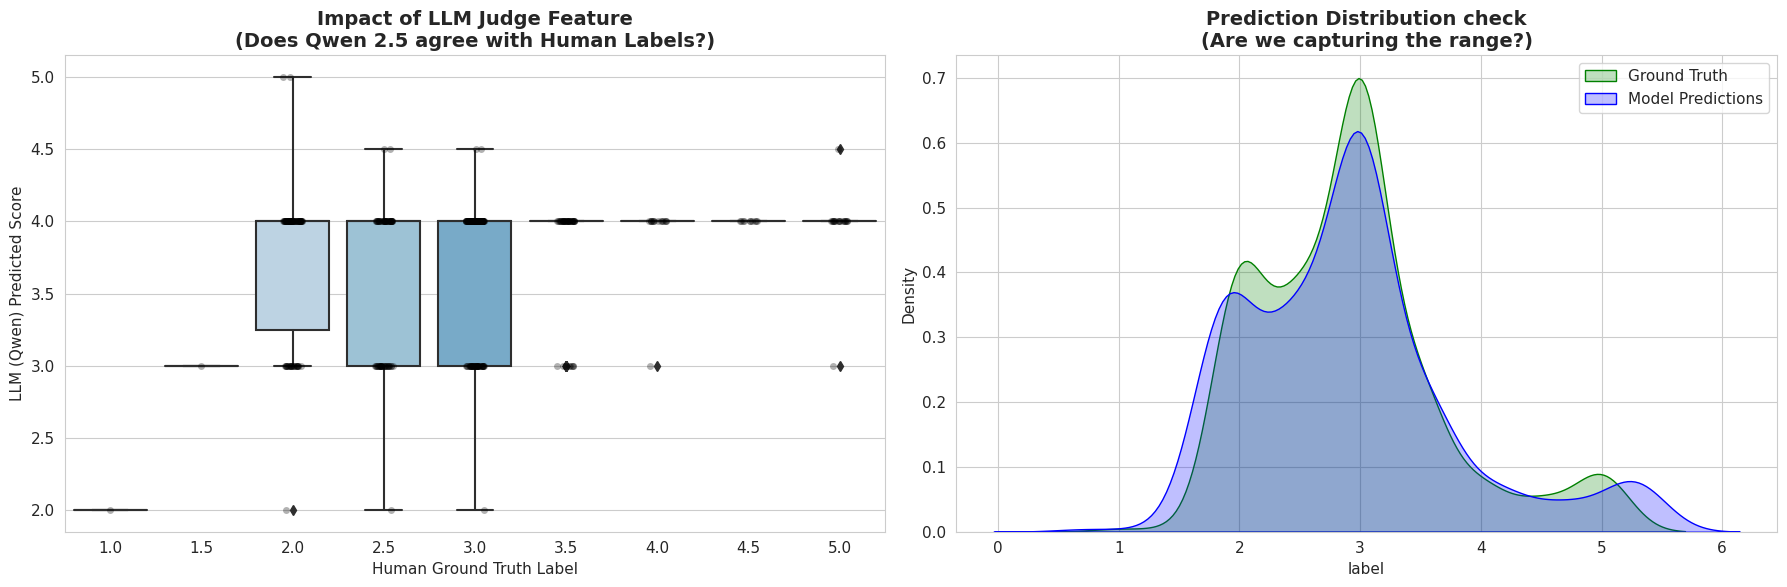

# 🏆 FINAL TRAINING RMSE: **0.1047**

### Pearson Correlation: **0.9990**

In [17]:
## 7.  INTERPRETABILITY & REPORT
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 11})

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- PLOT 1: LLM Judge vs Ground Truth ---
# This proves why adding Qwen was a good idea
sns.boxplot(data=train_df, x='label', y='llm_judge', ax=axes[0], palette="Blues")
sns.stripplot(data=train_df, x='label', y='llm_judge', color='black', alpha=0.3, jitter=True, ax=axes[0])
axes[0].set_title('Impact of LLM Judge Feature\n(Does Qwen 2.5 agree with Human Labels?)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Human Ground Truth Label')
axes[0].set_ylabel('LLM (Qwen) Predicted Score')

# --- PLOT 2: Prediction Distribution ---
sns.kdeplot(train_df['label'], fill=True, label='Ground Truth', color='green', ax=axes[1])
sns.kdeplot(train_preds, fill=True, label='Model Predictions', color='blue', ax=axes[1])
axes[1].set_title('Prediction Distribution check\n(Are we capturing the range?)', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

# --- COMPULSORY RMSE DISPLAY ---
import IPython.display as display
display.display(display.Markdown(f"# 🏆 FINAL TRAINING RMSE: **{train_rmse:.4f}**"))
display.display(display.Markdown(f"### Pearson Correlation: **{train_pearson:.4f}**"))
